# Feature Retrieval and Consumption for Model Training

Instead of using feature_store.yaml and feast CLI, use SDK.

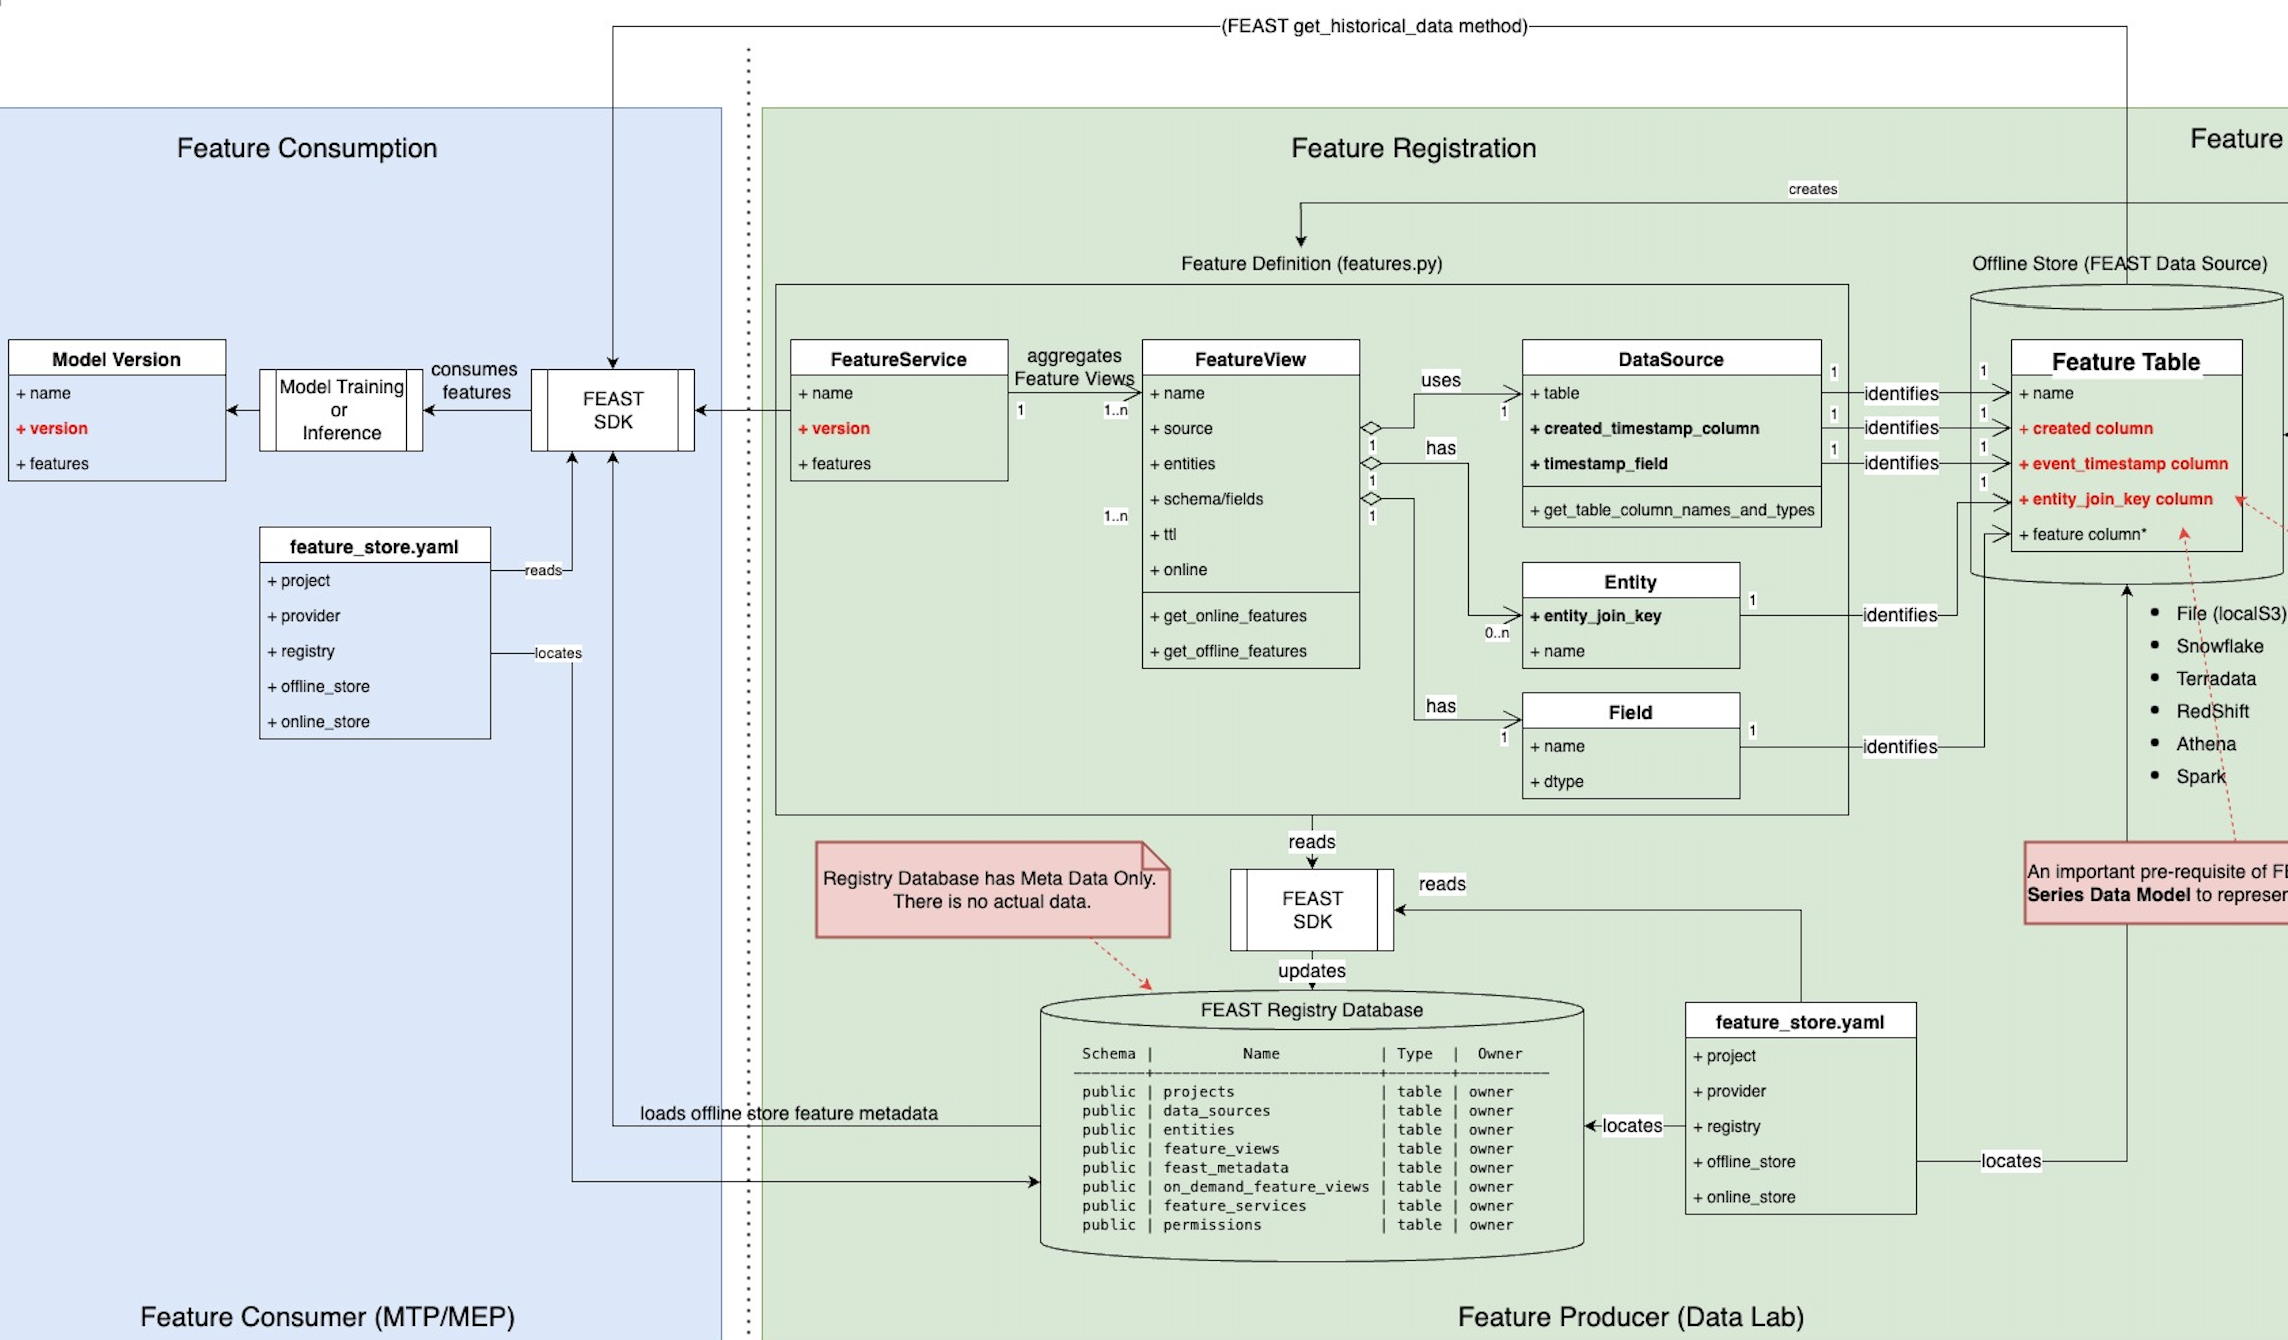

# Setup

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import json
import os
import sys
import subprocess
from datetime import (
    datetime,
    timedelta
)
import warnings

import pandas as pd
from feast import (
    Entity,
    FeatureService,
    FeatureView,
    Field,
    FileSource,
    Project,
    PushSource,
    RequestSource,
    RepoConfig,
)
from feast.repo_config import (
    RegistryConfig
)
from feast.infra.registry.sql import (
    SqlRegistryConfig
)
from feast.feature_logging import LoggingConfig
from feast.infra.offline_stores.file_source import FileLoggingDestination
from feast.infra.online_stores.sqlite import (
    SqliteOnlineStoreConfig
)
from feast.infra.offline_stores.contrib.postgres_offline_store.postgres import (
    PostgreSQLOfflineStoreConfig
)
from feast.on_demand_feature_view import on_demand_feature_view
from feast.types import (
    Float32, Float64, Int64
)
from feast.value_type import (
    ValueType
)
from feast import FeatureStore
from feast.data_source import PushMode


pd.set_option('display.max_colwidth', None)   # Prevent shortening of column values
pd.set_option('display.max_seq_items', None)  # Prevent truncation of sequences
pd.set_option('display.expand_frame_repr', False)  # Keep everything in one line per column
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
pythonpath = os.path.abspath(
    os.path.join(os.getcwd(), '..', 'deployment/feast/feature_repository')
)
if pythonpath not in sys.path:
    sys.path.append(pythonpath)

In [4]:
%load_ext autoreload
%autoreload 2

from psql import (
    batch_insert_with_progress,
    exists_table,
    get_all_tables,
    truncate,
    select_one,
    get_password_from_pgpass,
)
from utility import (
    read_yaml
)

In [5]:
NOTEBOOK_DIR: str = os.getcwd()
FEATURE_REPO_DIR: str = os.path.abspath(os.sep.join(
    [NOTEBOOK_DIR, "../deployment/feast/feature_repository"]
))

--- 
# FEAST Project

In [6]:
feature_store_config = read_yaml(f"{FEATURE_REPO_DIR}/feature_store.yaml")
repo_config = RepoConfig(
    registry=SqlRegistryConfig(
        path="postgresql+psycopg2://postgres@localhost:5432/feast_registry", 
        registry_type="sql",
        sqlalchemy_config_kwargs={
            "echo": False,
            "pool_pre_ping": True,
        }
    ),
    project="customer_credit_risk",
    provider="local",
    offline_store=PostgreSQLOfflineStoreConfig(**feature_store_config['offline_store']),
    online_store=SqliteOnlineStoreConfig(path=f'{FEATURE_REPO_DIR}/data/online_store.db')
)

In [7]:
feature_store = FeatureStore(config=repo_config)

## Result

In [8]:
for project in feature_store.list_projects():
    print(project)

for fv in feature_store.list_feature_views():
    print(f"FeatureView: {fv.name}")
    for feature in fv.features:
        print(f"  Feature: {feature.name} ({feature.dtype})")

for fs in feature_store.list_feature_services():
    print(f"\nFeatureService: {fs.name}")
    for projection in fs.feature_view_projections:
        print(f"  FeatureProjection: {projection.name}")
        for feature in projection.features:
            print(f"    Feature: {feature.name} ({feature.dtype})")

{
  "spec": {
    "name": "customer_credit_risk",
    "description": "A project for customer credit risk"
  },
  "meta": {
    "createdTimestamp": "2025-09-16T09:20:26.068510Z",
    "lastUpdatedTimestamp": "2025-09-16T09:20:26.068510Z"
  }
}
FeatureView: customer_credit_risk_feature_view
  Feature: risk (Float32)
  Feature: purpose_business (Float32)
  Feature: purpose_car (Float32)
  Feature: purpose_domestic_appliances (Float32)
  Feature: purpose_education (Float32)
  Feature: purpose_furniture_equipment (Float32)
  Feature: purpose_radio_tv (Float32)
  Feature: purpose_repairs (Float32)
  Feature: purpose_vacation_others (Float32)
  Feature: gender_female (Float32)
  Feature: gender_male (Float32)
  Feature: housing_free (Float32)
  Feature: housing_own (Float32)
  Feature: housing_rent (Float32)
  Feature: saving_accounts_little (Float32)
  Feature: saving_accounts_moderate (Float32)
  Feature: saving_accounts_no_inf (Float32)
  Feature: saving_accounts_quite_rich (Float32)
  Feat

---
# Feature Retrieval

## Offline Store

* [get_historical_features](https://rtd.feast.dev/en/master/#feast.feature_store.FeatureStore.get_historical_features)

> This method joins historical feature data from one or more feature views to an entity dataframe by using a time travel join. Each feature view is joined to the entity dataframe using all entities configured for the respective feature view.
>
> **Parameters**  
> * ```entity_df```: a collection of rows containing all entity columns (e.g., driver_id) on which features need to be joined, as well as a event_timestamp column used to ensure point-in-time correctness.
> 
> **Returns**: RetrievalJob which can be used to materialize the results.

* [RetrievalJob](https://rtd.feast.dev/en/master/#feast.infra.offline_stores.offline_store.RetrievalJob)

> A RetrievalJob manages the execution of a query to retrieve data from the offline store.  
> **Methods**  
> * [to_df](https://rtd.feast.dev/en/master/#feast.infra.offline_stores.offline_store.RetrievalJob.to_df): 
> Synchronously executes the underlying query and returns the result as a pandas dataframe. On demand transformations will be executed. 

### Use SQL as entity_df

* [Example: entity SQL query for generating training data](https://docs.feast.dev/getting-started/concepts/feature-retrieval#example-entity-sql-query-for-generating-training-data)


In [9]:
entity_sql = f"""
    SELECT
        entity_id,
        event_timestamp
    FROM {feature_store.get_data_source("customer_credit_risk_feature_source").get_table_query_string()} AS ENTITY_SQL
"""
print(entity_sql)

customer_credit_risk_feature_service = feature_store.get_feature_service(name="customer_credit_risk_feature_service")
training_df = feature_store.get_historical_features(
    entity_df=entity_sql,
    features=customer_credit_risk_feature_service,
).to_df()


    SELECT
        entity_id,
        event_timestamp
    FROM (SELECT * FROM credit.customer_credit_risk_offline_features) AS ENTITY_SQL



* [FEAST Feature Store - What is event_timestamp in entity_df parameter of FeatureStore.get_historical_features method](https://stackoverflow.com/q/79714277/4281353)

In [10]:
training_df.head(3)

,entity_id,event_timestamp,risk,purpose_business,purpose_car,purpose_domestic_appliances,purpose_education,purpose_furniture_equipment,purpose_radio_tv,purpose_repairs,purpose_vacation_others,gender_female,gender_male,housing_free,housing_own,housing_rent,saving_accounts_little,saving_accounts_moderate,saving_accounts_no_inf,saving_accounts_quite_rich,saving_accounts_rich,checking_account_little,checking_account_moderate,checking_account_no_inf,checking_account_rich,generation_student,generation_young,generation_adult,generation_senior,job_0,job_1,job_2,job_3,amount_0,amount_1,amount_2,amount_3,amount_4
0,1,2025-09-16 19:20:10.810806,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,2025-09-16 19:20:10.810806,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,2025-09-16 19:20:10.810806,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0



## Online Store

Need to run the materialization command to get columns from the online store.

### Materialise

In [11]:
event_timestamp = training_df.head(1)['event_timestamp'].to_list()[0].to_pydatetime()

In [12]:
feature_store.materialize(start_date=event_timestamp, end_date=datetime.now())

Materializing 1 feature views from 2025-09-16 19:20:10+00:00 to 2025-09-16 19:21:32+00:00 into the sqlite online store.

customer_credit_risk_feature_view:


### Issue

[FeatureStore.get_online_features() throws FeatureViewNotFoundException #5606](https://github.com/feast-dev/feast/issues/5606)

> FeatureViewNotFoundException: Feature view customer_credit_risk_customer_credit_risk_feature_view does not exist in project customer_credit_risk

In [13]:
feature_vector = feature_store.get_online_features(
    features=customer_credit_risk_feature_service,
    entity_rows=[
        {"entity_id": 1},
        {"entity_id": 2},
    ]
).to_df()

In [14]:
feature_vector

,entity_id,saving_accounts_moderate,housing_rent,amount_2,job_0,purpose_vacation_others,checking_account_moderate,saving_accounts_rich,purpose_domestic_appliances,job_2,amount_3,purpose_radio_tv,purpose_business,checking_account_no_inf,generation_young,amount_0,amount_1,purpose_education,purpose_furniture_equipment,generation_student,risk,checking_account_little,purpose_car,housing_free,gender_male,job_1,job_3,amount_4,generation_senior,purpose_repairs,checking_account_rich,generation_adult,gender_female,saving_accounts_no_inf,saving_accounts_quite_rich,saving_accounts_little,housing_own
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


# Feature Server

* [Python feature server](https://docs.feast.dev/reference/feature-servers/python-feature-server)

Does not work:

```
curl -X POST "http://localhost:8999/get-online-features" -d '{
    "features": [
      "customer_credit_risk_feature_view:purpose_business"
    ],
    "entities": {
      "entity_id": [1,2]
    }
}'
--------------------------------------------------------------------------------
{
  "detail": [
    {
      "type": "model_attributes_type",
      "loc": [
        "body"
      ],
      "msg": "Input should be a valid dictionary or object to extract fields from",
      "input": "{\n    \"features\": [\n      \"customer_credit_risk_feature_view:purpose_business\"\n    ],\n    \"entities\": {\n      \"entity_id\": [1,2]\n    }\n}"
    }
  ]
}
```

In [15]:
# feature_store.serve(host='localhost', port=8999)

# UI Server

Does not work with ```TypeError: FeatureStore.serve_ui() missing 1 required positional argument: 'get_registry_dump'```.

[[Beta] Web UI](https://docs.feast.dev/reference/alpha-web-ui) did not provide the **get_registry_dump'**.

```
Usage: feast ui [OPTIONS]

Shows the Feast UI over the current directory

Options:
-h, --host TEXT                 Specify a host for the server [default: 0.0.0.0]
-p, --port INTEGER              Specify a port for the server [default: 8888]
-r, --registry_ttl_sec INTEGER  Number of seconds after which the registry is refreshed. Default is 5 seconds.
--help                          Show this message and exit.
```

[serve_ui](https://rtd.feast.dev/en/master/index.html#feast.feature_store.FeatureStore.serve_ui) explain nothing.

In [16]:
# feature_store.serve_ui(host='localhost', port=8989, registry_ttl_sec=1, )

---

# Model Training

In [17]:
import numpy as np
from sklearn.feature_selection import (
    SelectKBest
)
from sklearn.model_selection import (
    cross_val_score,
    KFold,
    GridSearchCV,
    train_test_split
)

from sklearn.pipeline import (
    Pipeline,
    FeatureUnion
)
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [18]:
from evaluation import (
    evaluate_model
)

In [19]:
training_df.drop(columns=['entity_id', 'event_timestamp'], axis=1, inplace=True)
scale = sum(training_df['risk'] == False) / sum(training_df['risk'] == True)

In [20]:
#Creating the X and y variables
X = training_df.drop(columns=['risk'], axis=1)
y = training_df["risk"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [21]:
X.head(3)

,purpose_business,purpose_car,purpose_domestic_appliances,purpose_education,purpose_furniture_equipment,purpose_radio_tv,purpose_repairs,purpose_vacation_others,gender_female,gender_male,housing_free,housing_own,housing_rent,saving_accounts_little,saving_accounts_moderate,saving_accounts_no_inf,saving_accounts_quite_rich,saving_accounts_rich,checking_account_little,checking_account_moderate,checking_account_no_inf,checking_account_rich,generation_student,generation_young,generation_adult,generation_senior,job_0,job_1,job_2,job_3,amount_0,amount_1,amount_2,amount_3,amount_4
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Algorithsm Comparision


In [22]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('XGB', XGBClassifier(
    scale_pos_weight = scale
)))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Logistic Regression', LogisticRegression(
    penalty='l2',          # L2 regularization
    class_weight='balanced', # Automatically adjust weights for imbalanced classes
    solver='liblinear',    # good for small datasets and binary classification
    max_iter=1000,
    random_state=42
)))

# evaluate each model in turn
results = []
# scoring = 'recall'
scoring = 'f1'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append((name, cv_results))
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

results.sort(reverse=True, key=lambda x: x[1].mean())

XGB: 0.486110 (0.104101)
Gaussian Naive Bayes: 0.525474 (0.082965)
Logistic Regression: 0.599749 (0.080013)


# Train Models


## Logistic Regression

In [23]:
model = LogisticRegression(
    penalty='l2',          # L2 regularization
    class_weight='balanced', # Automatically adjust weights for imbalanced classes
    solver='liblinear',    # good for small datasets and binary classification
    max_iter=1000,
    random_state=42
)

In [24]:
param_grid_logistic = {
    'C': [0.01, 0.1, 1, 10, 100],          # inverse regularization strength
    'penalty': ['l2'],                      # L2 regularization
    'class_weight': ['balanced', None]     # try both balanced and default
}

# GridSearchCV with ROC AUC scoring
grid_logistic = GridSearchCV(
    estimator=model,
    param_grid=param_grid_logistic,
    scoring=scoring,
    cv=5,                # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
grid_logistic.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,LogisticRegre...r='liblinear')
,param_grid,"{'C': [0.01, 0.1, ...], 'class_weight': ['balanced', None], 'penalty': ['l2']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


Logistic regression best score: 0.5894372219310449
{
    "C": 0.01,
    "class_weight": "balanced",
    "penalty": "l2"
}
Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
Best ROC: 0.5894372219310449

Logistic Regression Results:
Confusion Matrix
[[115  63]
 [ 21  51]]
Accuracy: 0.6640
Recall: 0.7083
Precision: 0.4474
F1: 0.5484
AUC: 0.7365
classification report
              precision    recall  f1-score   support

         0.0       0.85      0.65      0.73       178
         1.0       0.45      0.71      0.55        72

    accuracy                           0.66       250
   macro avg       0.65      0.68      0.64       250
weighted avg       0.73      0.66      0.68       250



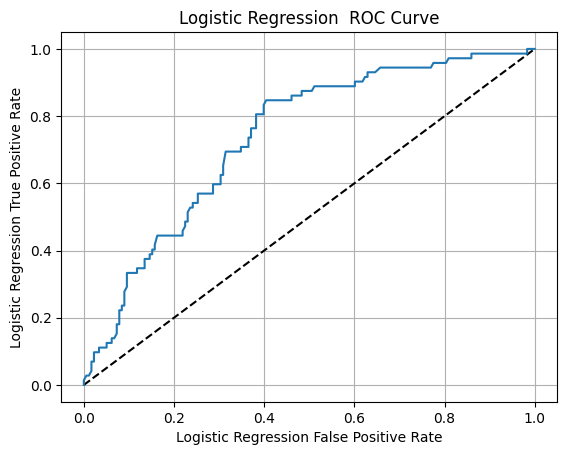

In [25]:
print(f"Logistic regression best score: {grid_logistic.best_score_}")
print(json.dumps(grid_logistic.best_params_, indent=4, default=str))

# Best parameters and score
print("Best parameters:", grid_logistic.best_params_)
print("Best ROC:", grid_logistic.best_score_)

# Evaluate on test set
best_logistic_model = grid_logistic.best_estimator_
y_pred_logistic = best_logistic_model.predict(X_test)
_ = evaluate_model(best_logistic_model, X_test, y_test, "Logistic Regression")

NOTE: SKLearn Confusion Matrix format:

```
[[TN FP]
 [FN TP]]
```



## GNB

* [Scikit-Learn GridSearchCV GaussianNB](https://sklearner.com/scikit-learn-grid-search-gaussiannb/)

In [26]:
features = []
features.append(('pca', PCA(n_components=2)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', GaussianNB()))
model = Pipeline(estimators)

# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

0.6946666666666668


In [27]:
#model.fit(X_train, y_train)
# Define parameter grid
param_grid = {
    'feature_union__pca__n_components': [1, 2, 3],       # Try different PCA components
    'feature_union__select_best__k': [4, 6, 8],          # Try different number of selected features
    'logistic__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6], # GaussianNB hyperparameter
}

# Create GridSearchCV
grid_gnb = GridSearchCV(model, param_grid, cv=kfold, scoring=scoring, n_jobs=-1)

# Fit
grid_gnb.fit(X_train, y_train)

,estimator,Pipeline(step...aussianNB())])
,param_grid,"{'feature_union__pca__n_components': [1, 2, ...], 'feature_union__select_best__k': [4, 6, ...], 'logistic__var_smoothing': [1e-09, 1e-08, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformer_list,"[('pca', ...), ('select_best', ...)]"


GNB best score: 0.5516661003209277
{
    "feature_union__pca__n_components": 3,
    "feature_union__select_best__k": 4,
    "logistic__var_smoothing": 1e-09
}

Gaussian NB Results:
Confusion Matrix
[[128  50]
 [ 27  45]]
Accuracy: 0.6920
Recall: 0.6250
Precision: 0.4737
F1: 0.5389
AUC: 0.7239
classification report
              precision    recall  f1-score   support

         0.0       0.83      0.72      0.77       178
         1.0       0.47      0.62      0.54        72

    accuracy                           0.69       250
   macro avg       0.65      0.67      0.65       250
weighted avg       0.72      0.69      0.70       250



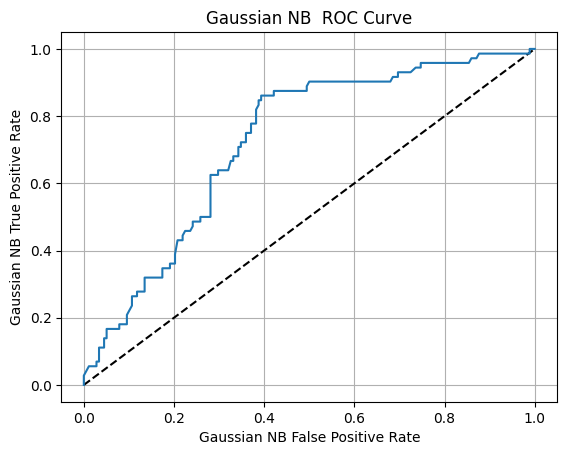

In [28]:
print(f"GNB best score: {grid_gnb.best_score_}")
print(json.dumps(grid_gnb.best_params_, indent=4, default=str))

# y_pred_gnb = model.predict(X_test)
best_gnb_model = grid_gnb.best_estimator_
y_pred_gnb = best_gnb_model.predict(X_test)

_ = evaluate_model(best_gnb_model, X_test, y_test, "Gaussian NB")

## XGB

In [ ]:
param_xgb = {
    'max_depth': [3, 5, 8],
    'min_child_weight': [1, 5, 8],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.1, 0.3, 0.5]
}

#Creating the classifier
model_xg = XGBClassifier(
    random_state=2, 
    n_jobs=-1,
    scale_pos_weight=scale,
    eval_metric="auc"
)

grid_xb = GridSearchCV(model_xg, param_grid=param_xgb, cv=5, scoring=scoring)
grid_xb.fit(X_train, y_train)

In [ ]:
# For XGBoost
feature_importance = grid_xb.best_estimator_.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df.sort_values('importance', ascending=False).head(10)

In [ ]:
grid_xb.best_score_
grid_xb.best_params_

_ = evaluate_model(grid_xb.best_estimator_, X_test, y_test, "XGBoost")